# Week 3 - Function 7 ((32DP, 6D))

# Setup

In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.svm import SVC, SVR
from scipy.stats.qmc import LatinHypercube
from ipywidgets import interact, FloatSlider

from utils.plotting_utils import (
    plot_6D_blackbox_analysis,
    plot_output_outliers,
    plot_bar_diff,
    plot_log_transform,
    plot_nd_mean_uncertainty_slice,
    plot_nd_svm_analysis_slice,
    plot_nd_acquisition_comparison_slice
)

# Plan
We now have ((32, 6)) - 32DP & 6D that can be found `./data/week_3/function_7/`.

1. Load data
2. Preprocessing (QuantileTransformer + Log Transform)
3. Build probabilistic Models (2-GP ensemble: QT + log-space)
4. SVM Analysis (Classifier + SVR surrogates)
5. Acquisition Function (SVM-constrained UCB, 2-GP ensemble)

# 1. Load data

In [2]:
X_train_raw = np.load(r"./data/week_3/function_7/inputs.npy")
y_train_raw = np.load(r"./data/week_3/function_7/outputs.npy")
print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(32, 6), y=(32,)
X range: [0.0036, 0.9987]
y range: [2.70e-03, 1.61e+00]


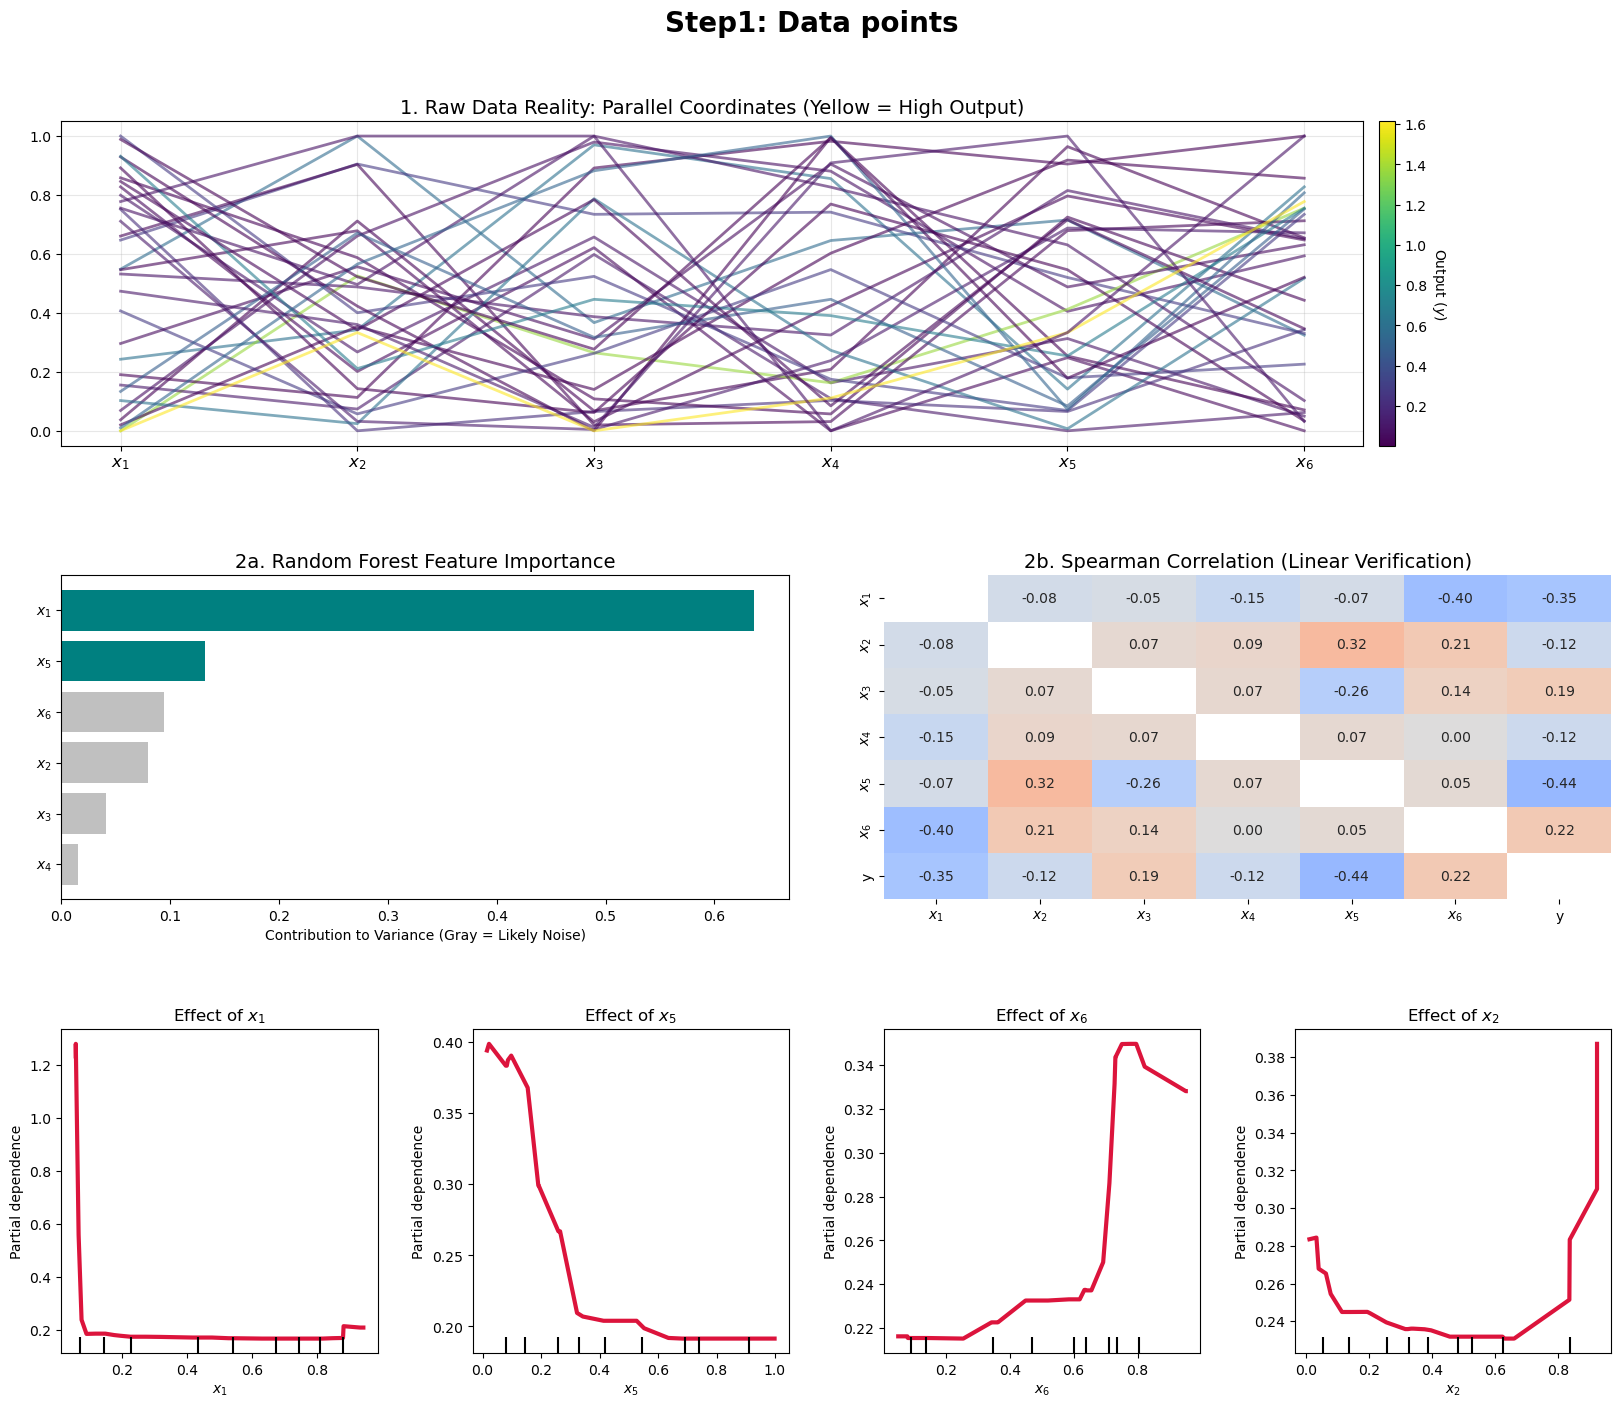

In [3]:
plot_6D_blackbox_analysis(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
{'='*30}
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}

CURRENT BEST
{'='*30}
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

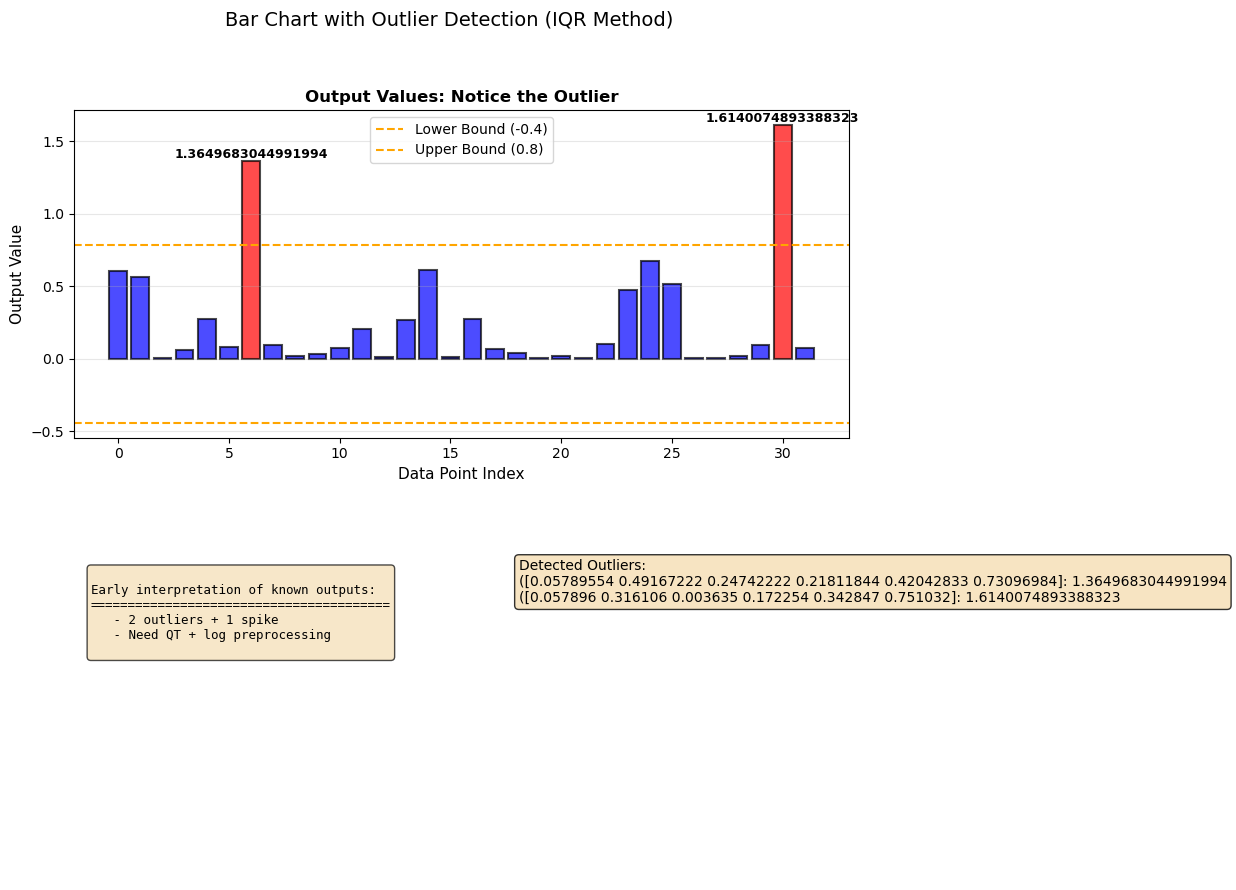

In [4]:
plot_output_outliers(X_train_raw, y_train_raw, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
{'='*40}
   - 2 outliers + 1 spike
   - Need QT + log preprocessing
""")

# 2. Preprocessing

Output has outlier spikes. Using QuantileTransformer + log10 shift.

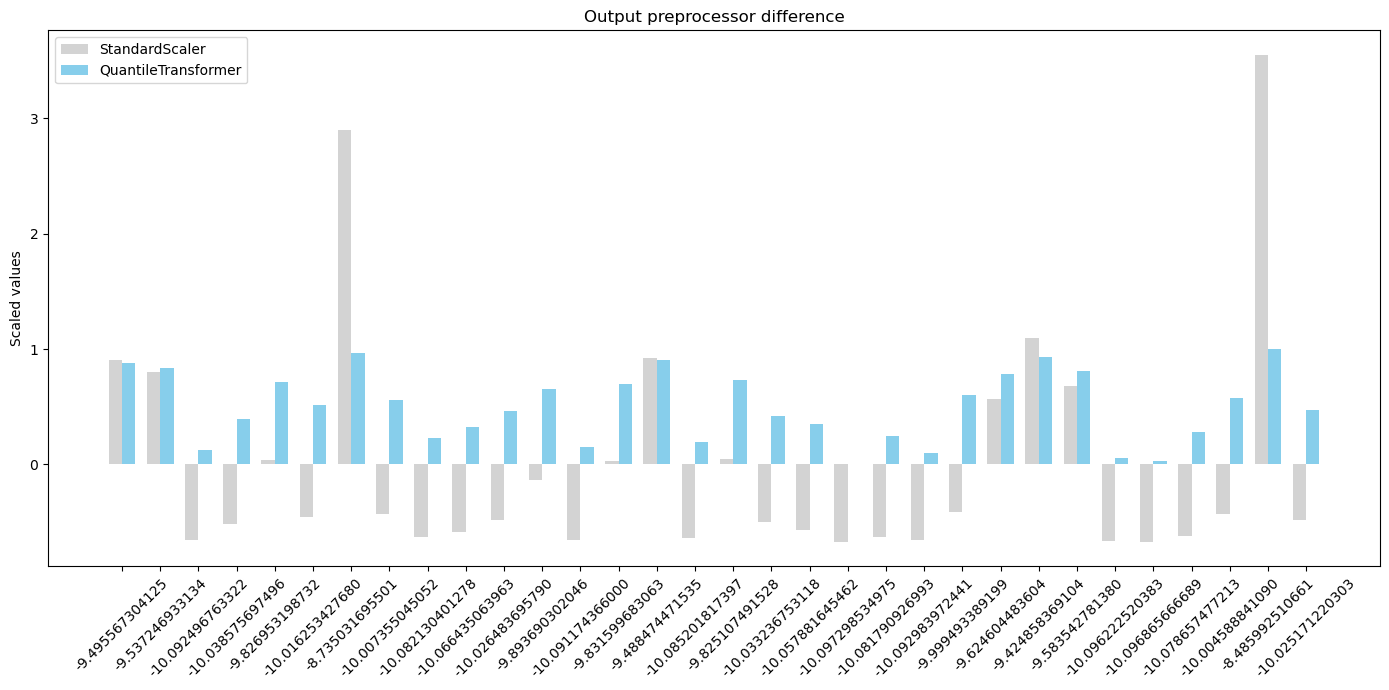

Total points: 32
QT range: [0.0, 1.0]


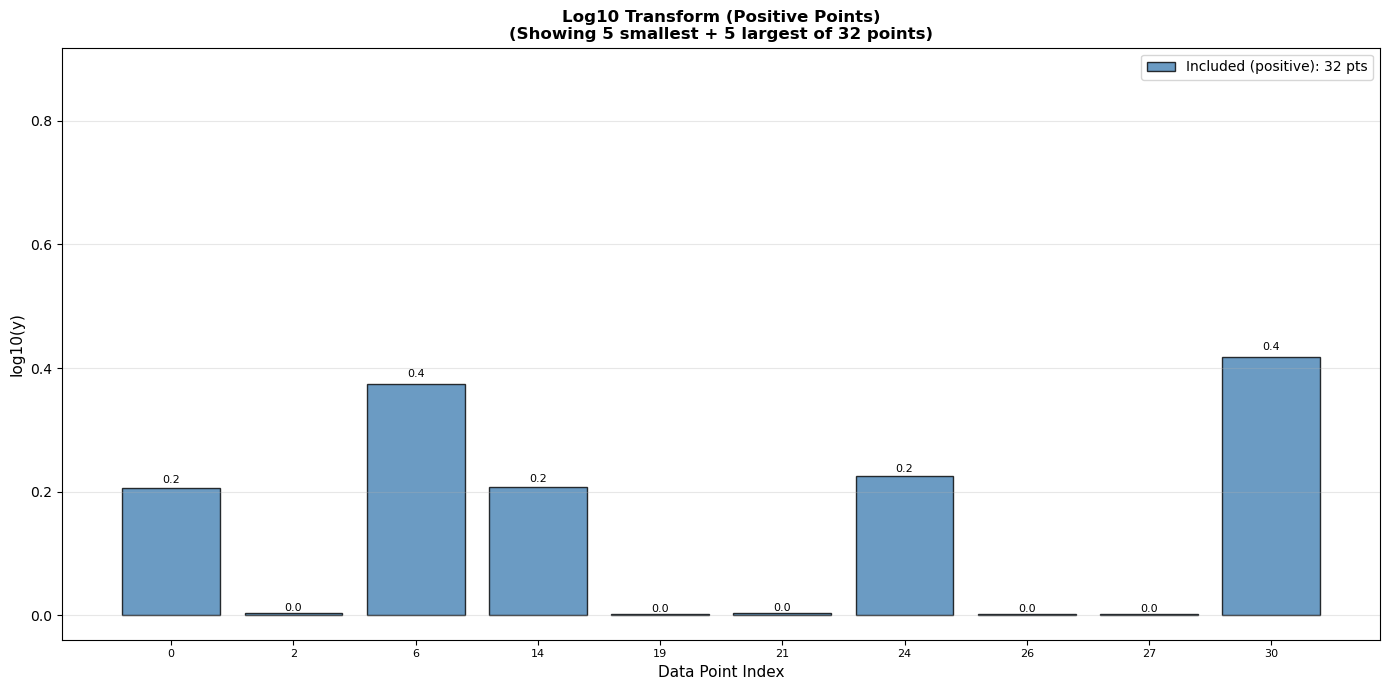


Log shift constant: 1.00
Positive points after shift: 32/32


In [5]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train_raw)

from sklearn.preprocessing import StandardScaler
scaler_ss = StandardScaler()
y_ss = scaler_ss.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

scaler_qt = QuantileTransformer(n_quantiles=len(y_train_raw)-1, output_distribution='uniform')
y_qt = scaler_qt.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

plot_bar_diff(y_train_raw, y_ss, y_qt, 'StandardScaler', 'QuantileTransformer',
              'Scaled values', 'Output preprocessor difference')

print(f"Total points: {len(X_train)}")
print(f"QT range: [{y_qt.min():.1f}, {y_qt.max():.1f}]")

# Log transform with shift
log_shift_constant = abs(y_train_raw.min()) + 1.0
y_train_raw_shifted = y_train_raw + log_shift_constant
pos_mask = y_train_raw_shifted > 0
X_train_pos = X_train[pos_mask]
y_log_pos = np.log10(y_train_raw_shifted[pos_mask])

plot_log_transform(y_train_raw, y_log_pos, pos_mask, show_top_n=5)

print(f"\nLog shift constant: {log_shift_constant:.2f}")
print(f"Positive points after shift: {pos_mask.sum()}/{len(y_train_raw)}")

# 3. Build probabilistic Models (2-GP ensemble)

- **gp_qt**: GP on QuantileTransformer output (all points)
- **gp_log**: GP on log10 output (positive points)

In [6]:
n_dims = 6

gp_qt = GaussianProcessRegressor(
    kernel=ConstantKernel(0.25, (1e-3, 10)) * Matern(
        length_scale=[0.5]*n_dims, nu=2.5,
        length_scale_bounds=(0.05, 100.0)
    ),
    alpha=0.01, normalize_y=True,
    n_restarts_optimizer=30
)

gp_log = GaussianProcessRegressor(
    kernel=ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
        length_scale=[0.5]*n_dims, nu=2.5,
        length_scale_bounds=(1e-3, 100.0)
    ),
    alpha=1e-4, normalize_y=True,
    n_restarts_optimizer=50
)

gp_qt.fit(X_train, y_qt)
gp_log.fit(X_train_pos, y_log_pos)

print(f"GP(QT) kernel: {gp_qt.kernel_}")
print(f"GP(log) kernel: {gp_log.kernel_}")

# Feature importance from ARD length scales
for name, gp in [('GP(QT)', gp_qt), ('GP(log)', gp_log)]:
    ls = gp.kernel_.k2.length_scale
    imp = 1.0 / ls
    imp_norm = imp / imp.sum() * 100
    print(f"\n{name} length scales: {ls}")
    sorted_dims = np.argsort(ls)
    for i in sorted_dims:
        role = 'IMPORTANT' if ls[i] < 1.0 else ('moderate' if ls[i] < 5.0 else 'noise')
        print(f"  x{i+1}: ls={ls[i]:.4f}, importance={imp_norm[i]:.1f}%, {role}")

# Determine plot/slider dims from gp_qt
ls_qt = gp_qt.kernel_.k2.length_scale
sorted_dims = np.argsort(ls_qt)
most_important = sorted_dims[:2]  # plot these
least_important = sorted_dims[2:]  # 4 sliders
dim_a, dim_b = most_important[0], most_important[1]
slider_dims = least_important
print(f"\nPlotting dims: x{dim_a+1}, x{dim_b+1}")
print(f"Slider dims: {['x'+str(d+1) for d in slider_dims]}")

/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP(QT) kernel: 1.07**2 * Matern(length_scale=[1.53, 0.581, 100, 0.416, 0.431, 0.473], nu=2.5)
GP(log) kernel: 0.934**2 * Matern(length_scale=[1.23, 0.837, 100, 3.46, 0.269, 0.133], nu=2.5)

GP(QT) length scales: [  1.53242782   0.58081324 100.           0.41623293   0.43141316
   0.47308055]
  x4: ls=0.4162, importance=26.1%, IMPORTANT
  x5: ls=0.4314, importance=25.1%, IMPORTANT
  x6: ls=0.4731, importance=22.9%, IMPORTANT
  x2: ls=0.5808, importance=18.7%, IMPORTANT
  x1: ls=1.5324, importance=7.1%, moderate
  x3: ls=100.0000, importance=0.1%, noise

GP(log) length scales: [  1.23454472   0.83688594 100.           3.45968438   0.26900982
   0.13343109]
  x6: ls=0.1334, importance=55.4%, IMPORTANT
  x5: ls=0.2690, importance=27.5%, IMPORTANT
  x2: ls=0.8369, importance=8.8%, IMPORTANT
  x1: ls=1.2345, importance=6.0%, moderate
  x4: ls=3.4597, importance=2.1%, moderate
  x3: ls=100.0000, importance=0.1%, noise

Plotting dims: x4, x5
Slider dims: ['x6', 'x2', 'x1', 'x3']


/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


### Interactive GP Slices

In [7]:
n_grid_2d = 40
x_plot_1 = np.linspace(0, 1, n_grid_2d)
x_plot_2 = np.linspace(0, 1, n_grid_2d)
X1_plot, X2_plot = np.meshgrid(x_plot_1, x_plot_2)

X_train_neg = X_train[~pos_mask]

def plot_gp_slices(**kwargs):
    grid_nd = np.zeros((n_grid_2d * n_grid_2d, n_dims))
    grid_nd[:, dim_a] = X1_plot.ravel()
    grid_nd[:, dim_b] = X2_plot.ravel()
    for d in slider_dims:
        grid_nd[:, d] = kwargs[f'x{d+1}']
    
    fixed_parts = [f'x{d+1}={kwargs[f"x{d+1}"]:.2f}' for d in slider_dims]
    fixed_info = ', '.join(fixed_parts)
    
    mu_qt, sigma_qt = gp_qt.predict(grid_nd, return_std=True)
    plot_nd_mean_uncertainty_slice(
        X_train, X1_plot, X2_plot,
        mu_qt.reshape(n_grid_2d, n_grid_2d),
        sigma_qt.reshape(n_grid_2d, n_grid_2d),
        dim1_idx=dim_a, dim2_idx=dim_b,
        title_prefix='GP (QT)', fixed_info=fixed_info
    )
    
    mu_log, sigma_log = gp_log.predict(grid_nd, return_std=True)
    plot_nd_mean_uncertainty_slice(
        X_train_pos, X1_plot, X2_plot,
        mu_log.reshape(n_grid_2d, n_grid_2d),
        sigma_log.reshape(n_grid_2d, n_grid_2d),
        dim1_idx=dim_a, dim2_idx=dim_b,
        X_excluded=X_train_neg,
        title_prefix='GP (log)', fixed_info=fixed_info
    )

slider_kwargs = {f'x{d+1}': FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{d+1}') for d in slider_dims}
interact(plot_gp_slices, **slider_kwargs)

interactive(children=(FloatSlider(value=0.5, description='x6', max=1.0, step=0.05), FloatSlider(value=0.5, des…

<function __main__.plot_gp_slices(**kwargs)>

# 4. SVM Analysis

In [8]:
# SVM Classifier
svm_labels = np.zeros(len(y_train_raw), dtype=int)
for i, yi in enumerate(y_log_pos):
    if yi > np.median(y_log_pos):
        svm_labels[np.where(pos_mask)[0][i]] = 1

svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train, svm_labels)

# SVR surrogates
svr_log = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.5)
svr_log.fit(X_train_pos, y_log_pos)

svr_qt = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_qt.fit(X_train, y_qt)

print(f"SVM labels: {svm_labels.sum()} promising, {(1-svm_labels).sum()} not promising")

# Interactive SVM slices
def plot_svm_slices(**kwargs):
    grid_nd = np.zeros((n_grid_2d * n_grid_2d, n_dims))
    grid_nd[:, dim_a] = X1_plot.ravel()
    grid_nd[:, dim_b] = X2_plot.ravel()
    for d in slider_dims:
        grid_nd[:, d] = kwargs[f'x{d+1}']
    
    fixed_parts = [f'x{d+1}={kwargs[f"x{d+1}"]:.2f}' for d in slider_dims]
    fixed_info = ', '.join(fixed_parts)
    
    svm_proba_slice = svm_clf.predict_proba(grid_nd)[:, 1]
    mu_svr_log_slice = svr_log.predict(grid_nd)
    mu_svr_qt_slice = svr_qt.predict(grid_nd)
    
    plot_nd_svm_analysis_slice(
        X1_plot, X2_plot,
        svm_proba_slice.reshape(n_grid_2d, n_grid_2d),
        mu_svr_log_slice.reshape(n_grid_2d, n_grid_2d),
        mu_svr_qt_slice.reshape(n_grid_2d, n_grid_2d),
        X_train, X_train_pos, X_train_neg, svm_labels,
        dim1_idx=dim_a, dim2_idx=dim_b, fixed_info=fixed_info
    )

slider_kwargs_svm = {f'x{d+1}': FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{d+1}') for d in slider_dims}
interact(plot_svm_slices, **slider_kwargs_svm)

SVM labels: 16 promising, 16 not promising


interactive(children=(FloatSlider(value=0.5, description='x6', max=1.0, step=0.05), FloatSlider(value=0.5, des…

<function __main__.plot_svm_slices(**kwargs)>

# 5. Acquisition Function (SVM-constrained UCB Ensemble)

50,000 LHS candidates in [0,1]^6 for adequate coverage of the 6D space.

In [10]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

def constrained_ucb(ucb_vals, svm_proba):
    ucb_shifted = ucb_vals - ucb_vals.min() + 1e-6
    return ucb_shifted * svm_proba

def normalize_01(arr):
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

# Generate LHS candidates
sampler = LatinHypercube(d=n_dims, seed=42)
X_candidates = sampler.random(n=50_000)

kappa = 5.0

# GP predictions on candidates
mu_gp_qt, sigma_gp_qt = gp_qt.predict(X_candidates, return_std=True)
mu_gp_log, sigma_gp_log = gp_log.predict(X_candidates, return_std=True)

# SVM probability
svm_proba = svm_clf.predict_proba(X_candidates)[:, 1]

# UCB scores
ucb_gp_qt = upper_confidence_bound(mu_gp_qt, sigma_gp_qt, kappa=kappa)
ucb_gp_log = upper_confidence_bound(mu_gp_log, sigma_gp_log, kappa=kappa)

# Constrained UCBs
ucb_c_gp_qt = constrained_ucb(ucb_gp_qt, svm_proba)
ucb_c_gp_log = constrained_ucb(ucb_gp_log, svm_proba)

# Ensemble
ensemble_ucb = (normalize_01(ucb_c_gp_qt) + normalize_01(ucb_c_gp_log)) / 2.0

best_ensemble_idx = np.argmax(ensemble_ucb)
x_next_norm = X_candidates[best_ensemble_idx]
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

# Per-surrogate bests
surrogates = {'GP (y_qt)': ucb_c_gp_qt, 'GP (y_log)': ucb_c_gp_log}
best_points = {}
for name, ucb_vals in surrogates.items():
    idx = np.argmax(ucb_vals)
    best_points[name] = {
        'idx': idx, 'norm': X_candidates[idx],
        'orig': scaler_X.inverse_transform([X_candidates[idx]])[0],
        'svm_p': svm_proba[idx]
    }

# Interactive acquisition slices
def plot_acq_slices(**kwargs):
    grid_nd = np.zeros((n_grid_2d * n_grid_2d, n_dims))
    grid_nd[:, dim_a] = X1_plot.ravel()
    grid_nd[:, dim_b] = X2_plot.ravel()
    for d in slider_dims:
        grid_nd[:, d] = kwargs[f'x{d+1}']
    
    fixed_parts = [f'x{d+1}={kwargs[f"x{d+1}"]:.2f}' for d in slider_dims]
    fixed_info = ', '.join(fixed_parts)
    
    mu_qt_s, sigma_qt_s = gp_qt.predict(grid_nd, return_std=True)
    mu_log_s, sigma_log_s = gp_log.predict(grid_nd, return_std=True)
    svm_p_s = svm_clf.predict_proba(grid_nd)[:, 1]
    
    ucb_qt_s = constrained_ucb(upper_confidence_bound(mu_qt_s, sigma_qt_s, kappa), svm_p_s)
    ucb_log_s = constrained_ucb(upper_confidence_bound(mu_log_s, sigma_log_s, kappa), svm_p_s)
    ens_s = (normalize_01(ucb_qt_s) + normalize_01(ucb_log_s)) / 2.0
    
    shape = (n_grid_2d, n_grid_2d)
    plot_nd_acquisition_comparison_slice(
        X1_plot, X2_plot,
        {'GP(QT)': ucb_qt_s.reshape(shape), 'GP(log)': ucb_log_s.reshape(shape)},
        svm_p_s.reshape(shape), ens_s.reshape(shape),
        X_train_pos, X_train_neg,
        dim1_idx=dim_a, dim2_idx=dim_b, fixed_info=fixed_info
    )

slider_kwargs_acq = {f'x{d+1}': FloatSlider(min=0, max=1, step=0.05, value=float(x_next_norm[d]), description=f'x{d+1}') for d in slider_dims}
interact(plot_acq_slices, **slider_kwargs_acq)

# Summary
print(f"{'='*80}")
print(f"RECOMMENDED NEXT POINT (Ensemble of 2 GPs, 50K LHS candidates)")
print(f"{'='*80}")
print(f"  Input (original space): {np.array_str(x_next_orig, precision=6)}")
print(f"  SVM P(promising):       {svm_proba[best_ensemble_idx]:.3f}")

print(f"\nIndividual surrogate suggestions:")
for name, bp in best_points.items():
    print(f"    {name:20s}: {np.array_str(bp['orig'], precision=6)} (SVM P={bp['svm_p']:.3f})")

print(f"\nSanity check - is this a corner?")
for i in range(n_dims):
    at_boundary = x_next_norm[i] < 0.02 or x_next_norm[i] > 0.98
    print(f"  x{i+1} = {x_next_norm[i]:.4f} {'<-- BOUNDARY!' if at_boundary else ''}")

print(f"\nCurrent best: {X_train_raw[np.argmax(y_train_raw)]} (y = {y_train_raw.max()})")

interactive(children=(FloatSlider(value=0.9739217478263387, description='x6', max=1.0, step=0.05), FloatSlider…

RECOMMENDED NEXT POINT (Ensemble of 2 GPs, 50K LHS candidates)
  Input (original space): [0.114794 0.107208 0.699622 0.61137  0.029816 0.927546]
  SVM P(promising):       0.891

Individual surrogate suggestions:
    GP (y_qt)           : [0.114794 0.107208 0.699622 0.61137  0.029816 0.927546] (SVM P=0.891)
    GP (y_log)          : [0.588739 0.021884 0.084091 0.095447 0.492882 0.818714] (SVM P=0.874)

Sanity check - is this a corner?
  x1 = 0.0643 
  x2 = 0.1045 
  x3 = 0.7557 
  x4 = 0.6060 
  x5 = 0.0151 <-- BOUNDARY!
  x6 = 0.9739 

Current best: [0.057896 0.316106 0.003635 0.172254 0.342847 0.751032] (y = 1.6140074893388323)
